In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

import os 
from tqdm import tqdm
import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [88]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset_final.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission_final.csv')

In [89]:
train = train.drop(['매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis=1)

In [90]:
train.shape, test.shape, submission.shape

((23009, 30), (4244, 29), (4244, 2))

In [91]:
train.iloc[:, :20].head(2)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,고객가입일,반려동물,부재중여부,우선청소,쿠폰사용여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9:00:00,13:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-04-22,NaN,NaN,NaN,0
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,10:00:00,16:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-05-21,없음,NaN,NaN,0


In [92]:
train.iloc[:, 20:].head(2)

,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부
0,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0
1,1976-06-10,0,안드로이드,대중교통,천안/아산,1.0,1.0,1,0,0


In [93]:
submission.head(2)

,SEQ,pred
0,T54370,0.5
1,T47892,0.5


## 기본 전처리

In [94]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일']).dt.year

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S')
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S')
train['서비스시작시간'] = train['서비스시작시간'].dt.hour
train['서비스종료시간'] = train['서비스종료시간'].dt.hour

# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
#test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S')
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S')
test['서비스시작시간'] = test['서비스시작시간'].dt.hour
test['서비스종료시간'] = test['서비스종료시간'].dt.hour

In [95]:
# 서비스소요시간
train['서비스소요시간'] = train['서비스종료시간'] - train['서비스시작시간']
test['서비스소요시간'] = test['서비스종료시간'] - test['서비스시작시간']

# 회차 관련
train['회차사용비율'] = train['현재회차'] / train['전체회차']
test['회차사용비율'] = test['현재회차'] / test['전체회차']
train['남은회차'] = train['전체회차'] - train['현재회차']
test['남은회차'] = test['전체회차'] - test['현재회차']
train['남은회차*회차사용비율'] = train['남은회차'] * train['회차사용비율']
test['남은회차*회차사용비율'] = test['남은회차'] * test['회차사용비율']

# 서비스일자 관련
train['최초서비스일_접수일'] = train['최초서비스일'] - train['접수일']
test['최초서비스일_접수일'] = test['최초서비스일'] - test['접수일']
train['서비스일자_최초서비스일'] = train['서비스일자'] - train['최초서비스일']
test['서비스일자_최초서비스일'] = test['서비스일자'] - test['최초서비스일']

In [96]:
# timedelta 형식 feature -> int형식으로
train['최초서비스일_접수일'] = train['최초서비스일_접수일'].dt.days.astype('int16')
test['최초서비스일_접수일'] = test['최초서비스일_접수일'].dt.days.astype('int16')

train['서비스일자_최초서비스일'] = train['서비스일자_최초서비스일'].dt.days.astype('int16')
test['서비스일자_최초서비스일'] = test['서비스일자_최초서비스일'].dt.days.astype('int16')

In [97]:
train['서비스사용_term'] = (train['서비스일자_최초서비스일'] / train['현재회차']).fillna(0)
test['서비스사용_term'] = (test['서비스일자_최초서비스일'] / test['현재회차']).fillna(0)

In [98]:
train['서비스사용_term_ratio'] = (train['서비스일자_최초서비스일'] / (train['최초서비스일_접수일']+1)).fillna(0)
test['서비스사용_term_ratio'] = (test['서비스일자_최초서비스일'] / (test['최초서비스일_접수일']+1)).fillna(0)

In [99]:
train['시간추가여부'] = train['서비스소요시간'].apply(lambda x : 1 if x not in ([2, 4, 6, 8, 10]) else 0)
test['시간추가여부'] = test['서비스소요시간'].apply(lambda x : 1 if x not in ([2, 4, 6, 8, 10]) else 0)

In [100]:
train['서비스종료시작_ratio'] = train['서비스시작시간'] / train['서비스종료시간']
test['서비스종료시작_ratio'] = test['서비스시작시간'] / test['서비스종료시간']

In [101]:
# 매니저나이
train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x)

운영시간

 - 4시간 : 오전 9:00 ~ 오후 1:00 / 오후 2:00 ~ 오후 6:00
   (기본 스케줄이며 상황에 따라 변경 가능)
   
 - 8시간 : 오전 9:00 ~ 오후 6:00 (휴게1시간 적용 / 매니저에게 중식 또는 중식비 제공 필수)
 
 - 10평대인 경우에만 2시간 서비스가 가능합니다
 
 https://helper.veteranscout.co.kr/house/house_mng

In [102]:
train.loc[train['서비스소요시간'] <= 3, '평수'] = train.loc[train['서비스소요시간'] <= 3, '평수'].fillna('10평대')

In [103]:
test.loc[test['서비스소요시간'] <= 3, '평수'] = test.loc[test['서비스소요시간'] <= 3, '평수'].fillna('10평대')

서비스 가능 지역
- 서울 / 천안, 아산, 평택 / 원주 / 부산 / 광주

In [104]:
set(train['근무가능지역'].unique()) - set(test['근무가능지역'].unique())

set()

In [105]:
set(test['근무가능지역'].unique()) - set(train['근무가능지역'].unique())

set()

In [106]:
set(train['서비스주소'].unique()) - set(test['서비스주소'].unique())

{'경남 창원시', '부산 동래구'}

In [107]:
set(test['서비스주소'].unique()) - set(train['서비스주소'].unique())

{'경기 화성시', '부산 금정구', '부산 부산진구', '부산 북구', '부산 사상구', '서울 광진구', '서울 송파구'}

### 고객 정보

In [108]:
# 장기서비스여부 / 기존고객여부 / 결재형태 / 서비스주소 / 주거형태 / 평수 / 고객가입일 / 반려동물 / 부재중여부 / 우선청소 /
# 쿠폰사용여부

In [109]:
# 고객 열 결측치 개수
na_sum = []
for i in range (0, train.shape[0], 1):
    na_all = train.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum.append(na_all)

na_sum_te = []
for i in range (0, test.shape[0], 1):
    na_all = test.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum_te.append(na_all)

na_df = pd.DataFrame(na_sum)
na_df.columns = ['na값']

na_df_te = pd.DataFrame(na_sum_te)
na_df_te.columns = ['na값']

train = pd.concat([train, na_df], axis=1)
test = pd.concat([test, na_df_te], axis=1)

In [110]:
train['반려동물'] = train['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                    if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)
test['반려동물'] = test['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                  if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)

### 매니저 정보

In [111]:
# public LB 1위 민석피셜 - 매니저를 살리려고 노력했다 -> 매니저 피처에 집중

In [112]:
# 매니저생년월일 / 매니저성별 / 매니저사용휴대폰 / 매니저이동방법 / 근무가능지역 / CS교육이수여부 / 청소교육이수여부 / 
# 부재중서비스가능여부 / 추천인여부 / 매니저나이

In [113]:
train[['매니저생년월일', '매니저성별', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부',
       '부재중서비스가능여부', '추천인여부', '매니저나이']].head(1)

,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매니저나이
0,1956,0,안드로이드,대중교통,서울,0.0,0.0,1,0,65


In [114]:
train[train['서비스소요시간'] == train['서비스소요시간'].max()]['평수'].unique()

array([nan, '10평대', '30평대', '20평대'], dtype=object)

In [115]:
test[test['서비스소요시간'] == test['서비스소요시간'].max()]['평수'].unique()

array([nan, '30평대', '20평대', '10평대'], dtype=object)

### 서비스 정보

In [116]:
# 접수일 / 접수시각 / 최초서비스일 / 전체회차 / 현재회차 / 서비스일자 / 서비스시작시간 / 서비스종료시간

In [117]:
# 접수일 기준
train['접수일_월'] = train['접수일'].dt.month
train['접수일_주차'] = train['접수일'].dt.week
train['접수일_일'] = train['접수일'].dt.day
train['접수일_요일'] = train['접수일'].dt.dayofweek

test['접수일_월'] = test['접수일'].dt.month
test['접수일_주차'] = test['접수일'].dt.week
test['접수일_일'] = test['접수일'].dt.day
test['접수일_요일'] = test['접수일'].dt.dayofweek

# 서비스일자 기준
train['서비스일자_월'] = train['서비스일자'].dt.month
train['서비스일자_주차'] = train['서비스일자'].dt.week
train['서비스일자_일'] = train['서비스일자'].dt.day
train['서비스일자_요일'] = train['서비스일자'].dt.dayofweek

test['서비스일자_월'] = test['서비스일자'].dt.month
test['서비스일자_주차'] = test['서비스일자'].dt.week
test['서비스일자_일'] = test['서비스일자'].dt.day
test['서비스일자_요일'] = test['서비스일자'].dt.dayofweek

In [118]:
# 예외시작시간여부
original_starttime = [9, 11, 14, 16]
train['예외시작시간여부'] = train['서비스시작시간'].apply(lambda x: 1 if x in original_starttime else 0)
test['예외시작시간여부'] = test['서비스시작시간'].apply(lambda x: 1 if x in original_starttime else 0)

In [119]:
train['접수일_fire여부'] = train['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['접수일_fire여부'] = test['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)

train['서비스일자_fire여부'] = train['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['서비스일자_fire여부'] = test['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)

In [120]:
# train, test셋의 구성이 다른 피처 처리 - 결제형태, 서비스주소
train['서비스주소'] = train.서비스주소.str[:2]
train['결재형태'] = train.결재형태.replace('미수', np.NaN) # or 드랍 
                               
test['서비스주소'] = test.서비스주소.str[:2]
test['결재형태'] = test.결재형태.replace('미수', np.NaN) # or 드랍

In [121]:

def goodmanager(x):
    if 50<= x <= 52:
        return 1
    else:
        return 0

train['지리는매니저'] = train['매니저나이'].apply(goodmanager)
test['지리는매니저'] = test['매니저나이'].apply(goodmanager)

In [122]:
train['매니저나이*전체회차']=train.매니저나이*train.전체회차
test['매니저나이*전체회차']=test.매니저나이*test.전체회차

In [123]:
train['매니저나이*현재회차']=train.매니저나이*train.현재회차
test['매니저나이*현재회차']=test.매니저나이*test.현재회차

In [124]:
train['매니저나이*회차사용비율']=train.매니저나이*train.회차사용비율
test['매니저나이*회차사용비율']=test.매니저나이*test.회차사용비율

In [125]:
train['매니저나이*서비스종료시작_ratio'] = train['매니저나이'] * train['서비스종료시작_ratio']
test['매니저나이*서비스종료시작_ratio'] = test['매니저나이'] * test['서비스종료시작_ratio']

In [126]:
train['매니저나이/서비스소요시간'] = train['매니저나이'] / train['서비스소요시간']
test['매니저나이/서비스소요시간'] = test['매니저나이'] / test['서비스소요시간']

In [127]:
train['매니저생년월일x매니저나이'] = train['매니저생년월일'] * train['매니저나이']
test['매니저생년월일x매니저나이'] = test['매니저생년월일'] * test['매니저나이']

In [128]:
train['띠'] = train['매니저생년월일']%12
test['띠'] = test['매니저생년월일']%12

In [129]:
train=pd.merge(train,train.groupby('매니저나이')['남은회차'].agg([('나이회차_평균','mean'),('나이회차_최대','max'),('나이회차_최소','min')]).reset_index(),how='left',on='매니저나이')
test=pd.merge(test,test.groupby('매니저나이')['남은회차'].agg([('나이회차_평균','mean'),('나이회차_최대','max'),('나이회차_최소','min')]).reset_index(),how='left',on='매니저나이')

In [130]:
train=pd.merge(train,train.groupby('매니저나이')['서비스소요시간'].agg([('나이시간_평균','mean'),('나이시간_최대','max'),('나이시간_최소','min')]).reset_index(),how='left',on='매니저나이')
test=pd.merge(test,test.groupby('매니저나이')['서비스소요시간'].agg([('나이시간_평균','mean'),('나이시간_최대','max'),('나이시간_최소','min')]).reset_index(),how='left',on='매니저나이')

## 데이터 셋 세팅

In [131]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저성별', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '매칭성공여부', '서비스소요시간', '회차사용비율', '남은회차', '남은회차*회차사용비율', '최초서비스일_접수일',
       '서비스일자_최초서비스일', '서비스사용_term', '서비스사용_term_ratio', '시간추가여부',
       '서비스종료시작_ratio', '매니저나이', 'na값', '접수일_월', '접수일_주차', '접수일_일', '접수일_요일',
       '서비스일자_월', '서비스일자_주차', '서비스일자_일', '서비스일자_요일', '예외시작시간여부', '접수일_fire여부',
       '서비스일자_fire여부', '지리는매니저', '매니저나이*전체회차', '매니저나이*현재회차', '매니저나이*회차사용비율',
       '매니저나이*서비스종료시작_ratio', '매니저나이/서비스소요시간', '매니저생년월일x매니저나이', '띠', '나이회차_평균',
       '나이회차_최대', '나이회차_최소', '나이시간_평균', '나이시간_최대', '나이시간_최소'],
      dtype='object')

In [132]:
features = ['장기서비스여부', '전체회차', '현재회차',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부',
       '서비스소요시간', '회차사용비율', '남은회차', '남은회차*회차사용비율', '최초서비스일_접수일',
       '서비스일자_최초서비스일', '서비스사용_term', '서비스사용_term_ratio', '시간추가여부',
       '서비스종료시작_ratio', '매니저나이', 'na값', '접수일_월', '접수일_주차', '접수일_일', '접수일_요일',
       '서비스일자_월', '서비스일자_주차', '서비스일자_일', '서비스일자_요일', '예외시작시간여부', '접수일_fire여부',
       '서비스일자_fire여부','지리는매니저','매니저나이*전체회차','매니저나이*현재회차','매니저나이*회차사용비율','매니저나이*서비스종료시작_ratio'
           ,'매니저나이/서비스소요시간','매니저생년월일x매니저나이','띠', '나이회차_평균',
       '나이회차_최대', '나이회차_최소', '나이시간_평균', '나이시간_최대', '나이시간_최소']

In [133]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

## 결측치 처리

In [134]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물']#, '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [135]:
# 한글로 구성되어 있는 피처 Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['주거형태', '평수', '우선청소', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', '결재형태', '서비스주소']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [136]:
ftr['평수'] = ftr.평수.replace(4, np.NaN)
ftr_te['평수'] = ftr_te.평수.replace(4, np.NaN)

ftr['우선청소'] = ftr.우선청소.replace(5, np.NaN)
ftr_te['우선청소'] = ftr_te.우선청소.replace(5, np.NaN)

ftr['매니저사용휴대폰']=ftr.매니저사용휴대폰.replace(3,np.NaN)
ftr_te['매니저사용휴대폰']=ftr_te.매니저사용휴대폰.replace(3,np.NaN)

ftr['매니저이동방법']=ftr.매니저이동방법.replace(2,np.NaN)
ftr_te['매니저이동방법']=ftr_te.매니저이동방법.replace(2,np.NaN)

ftr['CS교육이수여부']=ftr.CS교육이수여부.replace(2,np.NaN)
ftr_te['CS교육이수여부']=ftr_te.CS교육이수여부.replace(2,np.NaN)

ftr['청소교육이수여부']=ftr.청소교육이수여부.replace(2,np.NaN)
ftr_te['청소교육이수여부']=ftr_te.청소교육이수여부.replace(2,np.NaN)

In [137]:
ftr.shape, ftr_te.shape, target.shape

((23009, 57), (4244, 57), (23009,))

In [138]:
ftr

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,반려동물,부재중여부,우선청소,쿠폰사용여부,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,서비스소요시간,회차사용비율,남은회차,남은회차*회차사용비율,최초서비스일_접수일,서비스일자_최초서비스일,서비스사용_term,서비스사용_term_ratio,시간추가여부,서비스종료시작_ratio,매니저나이,na값,접수일_월,접수일_주차,접수일_일,접수일_요일,서비스일자_월,서비스일자_주차,서비스일자_일,서비스일자_요일,예외시작시간여부,접수일_fire여부,서비스일자_fire여부,지리는매니저,매니저나이*전체회차,매니저나이*현재회차,매니저나이*회차사용비율,매니저나이*서비스종료시작_ratio,매니저나이/서비스소요시간,매니저생년월일x매니저나이,띠,나이회차_평균,나이회차_최대,나이회차_최소,나이시간_평균,나이시간_최대,나이시간_최소
0,1,3,3,9,13,1,1,6,1,NaN,0.0,NaN,NaN,0,2.0,0.0,3,0.0,0.0,1,4,1.00,0,0.00,6,14,4.666667,2.000000,0,0.692308,65,4,7,28,9,1,7,31,29,0,1,0,0,0,195,195,65.00,45.000000,16.25,127140,0,2.243437,9,0,3.968974,9,2
1,1,4,3,10,16,1,1,6,1,NaN,0.0,NaN,NaN,0,2.0,0.0,6,1.0,1.0,1,6,0.75,1,0.75,3,36,12.000000,9.000000,0,0.625000,45,3,7,28,12,4,8,34,20,1,0,1,0,0,180,135,33.75,28.125000,7.50,88920,8,2.320175,27,0,3.960526,9,2
2,1,10,6,9,13,1,2,6,1,3.0,0.0,0.0,NaN,0,2.0,0.0,6,0.0,0.0,0,4,0.60,4,2.40,5,18,3.000000,3.000000,0,0.692308,51,1,11,47,18,2,12,50,11,4,1,0,1,1,510,306,30.60,35.307692,12.75,100470,2,2.384585,27,0,3.925331,9,2
3,1,4,4,9,14,1,1,5,1,2.0,0.0,0.0,1.0,0,2.0,0.0,3,0.0,0.0,1,5,1.00,0,0.00,0,21,5.250000,21.000000,1,0.642857,65,0,11,46,9,0,11,49,30,0,1,0,0,0,260,260,65.00,41.785714,13.00,127140,0,2.243437,9,0,3.968974,9,2
4,1,2,2,9,13,1,1,6,1,NaN,0.0,NaN,NaN,0,2.0,0.0,6,0.0,0.0,1,4,1.00,0,0.00,35,7,3.500000,0.194444,0,0.692308,55,4,2,9,25,1,4,15,7,1,1,0,0,0,110,110,55.00,38.076923,13.75,108130,10,2.424242,9,0,3.910873,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23004,1,4,1,16,18,1,2,0,0,1.0,1.0,1.0,0.0,0,2.0,1.0,6,0.0,0.0,1,2,0.25,3,0.75,1,0,0.000000,0.000000,0,0.888889,51,0,1,1,5,1,1,1,6,2,1,0,0,1,204,51,12.75,45.333333,25.50,100470,2,2.384585,27,0,3.925331,9,2
23005,1,10,9,14,18,1,2,6,1,NaN,0.0,NaN,NaN,1,2.0,0.0,6,0.0,0.0,1,4,0.90,1,0.90,28,105,11.666667,3.620690,0,0.777778,52,3,2,6,3,0,6,25,15,0,1,0,0,1,520,468,46.80,40.444444,13.00,102388,1,2.439340,29,0,3.938448,9,2
23006,1,4,3,9,13,1,2,0,1,2.0,0.0,1.0,NaN,0,2.0,0.0,6,0.0,0.0,1,4,0.75,1,0.75,20,27,9.000000,1.285714,0,0.692308,50,1,4,17,30,4,6,24,16,2,1,1,0,1,200,150,37.50,34.615385,12.50,98550,3,2.356621,27,0,3.954640,9,2
23007,1,4,3,14,18,1,2,6,1,NaN,0.0,NaN,NaN,0,2.0,1.0,6,1.0,1.0,1,4,0.75,1,0.75,2,14,4.666667,4.666667,0,0.777778,54,4,7,28,8,0,7,30,24,2,1,0,0,0,216,162,40.50,42.000000,13.50,106218,11,2.364154,9,0,3.921764,9,2


In [139]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', 
                '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', 
                '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부',  '남은회차', 
                '접수일_월', '접수일_주차', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_주차', '서비스일자_일', 
                '서비스일자_요일', '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부','시간추가여부','지리는매니저','띠']

In [140]:
cat_lst = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 28, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,43,50]

In [141]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [142]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

In [143]:
ftr_imputed['제발']=ftr_imputed.매니저나이*ftr_imputed.근무가능지역
ftr_te_imputed['제발']=ftr_te_imputed.매니저나이*ftr_te_imputed.근무가능지역

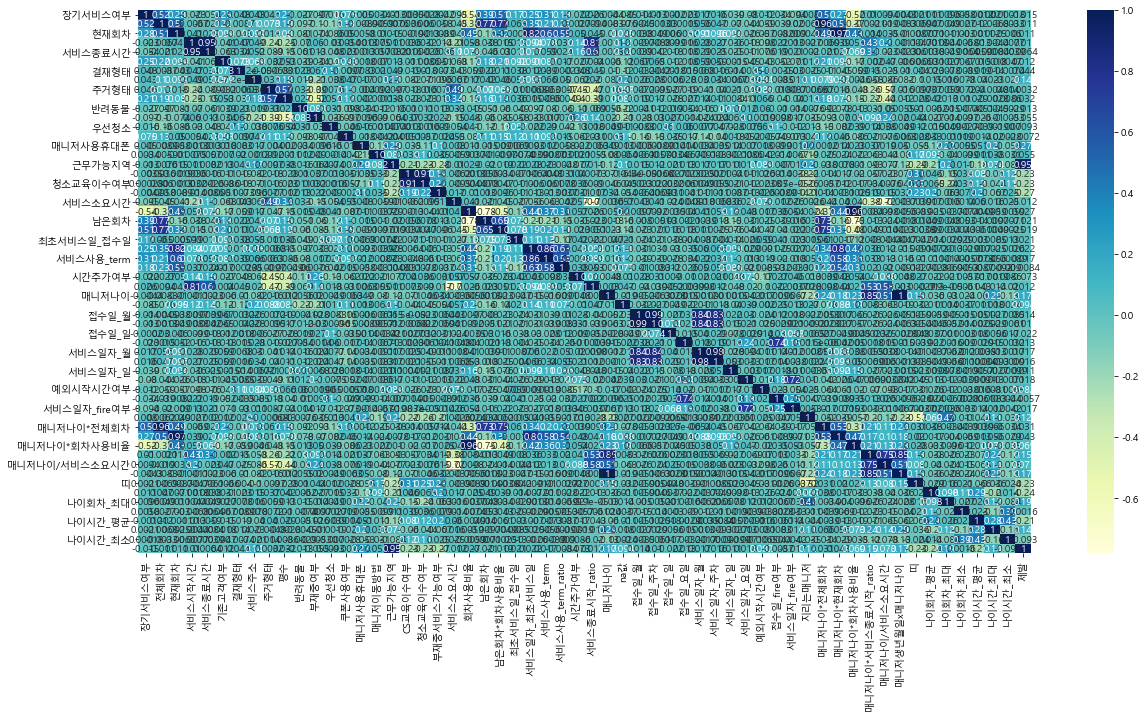

In [144]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 스케일링

In [145]:
num_features = list(set(ftr.columns) - set(cat_features))

In [146]:
num_features

['서비스사용_term',
 '매니저나이/서비스소요시간',
 '매니저나이*현재회차',
 '회차사용비율',
 '나이회차_최대',
 '현재회차',
 '서비스사용_term_ratio',
 '최초서비스일_접수일',
 '나이시간_최대',
 '남은회차*회차사용비율',
 '전체회차',
 '매니저생년월일x매니저나이',
 '서비스소요시간',
 '서비스일자_최초서비스일',
 '나이시간_평균',
 'na값',
 '서비스종료시작_ratio',
 '매니저나이*전체회차',
 '나이회차_평균',
 '매니저나이',
 '매니저나이*회차사용비율',
 '매니저나이*서비스종료시작_ratio',
 '나이시간_최소',
 '나이회차_최소']

### Gauss rank
* https://github.com/aldente0630/gauss_rank_scaler

In [147]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [148]:
scaler = GaussRankScaler()
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

## 모델링

In [149]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [150]:
kf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

In [151]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', 
                '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', 
                '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부',  '남은회차', 
                '접수일_월', '접수일_주차', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_주차', '서비스일자_일', 
                '서비스일자_요일', '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부','시간추가여부','지리는매니저','띠']

### Catboost

In [152]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(float)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(float)

ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [153]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [154]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [155]:
cb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='AUC', class_weights=class_weights,
                        silent=True, loss_function='Logloss')
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict_proba(val_x, ntree_end=best)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = cb.predict_proba(ftr_te_imputed, ntree_end=best)[:, 1] / 3
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

0:	test: 0.6714245	best: 0.6714245 (0)	total: 239ms	remaining: 39m 44s
2000:	test: 0.9639761	best: 0.9639761 (2000)	total: 2m 34s	remaining: 10m 16s
4000:	test: 0.9670016	best: 0.9670018 (3987)	total: 5m 14s	remaining: 7m 50s
6000:	test: 0.9680347	best: 0.9680524 (5254)	total: 7m 51s	remaining: 5m 14s
8000:	test: 0.9693706	best: 0.9693800 (7808)	total: 10m 36s	remaining: 2m 39s
9999:	test: 0.9696729	best: 0.9697309 (9534)	total: 13m 14s	remaining: 0us

bestTest = 0.9697308912
bestIteration = 9534

Shrink model to first 9535 iterations.
FOLD ROC-AUC = 0.9697297112327061
0:	test: 0.6860467	best: 0.6860467 (0)	total: 90.6ms	remaining: 15m 5s
2000:	test: 0.9669037	best: 0.9669113 (1998)	total: 2m 40s	remaining: 10m 41s
4000:	test: 0.9684549	best: 0.9684758 (3899)	total: 5m 21s	remaining: 8m 2s
6000:	test: 0.9688890	best: 0.9689969 (5493)	total: 8m 1s	remaining: 5m 20s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9689969421
bestIteration = 5493

Shrink model to firs

In [156]:
cb_pred.shape

(4244,)

In [157]:
cb_pred

array([0.00160685, 0.08944492, 0.51553793, ..., 0.09104356, 0.00338171,
       0.24199115])

## submission

In [161]:
submission['pred'] = cb_pred

In [159]:
submission['pred'] = submission['pred'].apply(lambda x : 1 if x >=0.5 else 0)

In [160]:
submission['pred'].value_counts()
# 251개 - 0.72
# 330개 - 0.82369
# 344개 - 0.79
# 334개 - 

0    3921
1     323
Name: pred, dtype: int64

In [163]:
submission['pred'] = cb_pred
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T54370,0.001607
T47892,0.089445
T56637,0.515538
T45487,0.001783
T41995,0.319413
...,...
T31589,0.053315
T36236,0.042077
T34729,0.091044


In [164]:
submission

,pred
SEQ,
T54370,0.001607
T47892,0.089445
T56637,0.515538
T45487,0.001783
T41995,0.319413
...,...
T31589,0.053315
T36236,0.042077
T34729,0.091044


In [165]:
submission.to_csv('1123_cb_gr_3fold_zoo.csv')

<AxesSubplot:>

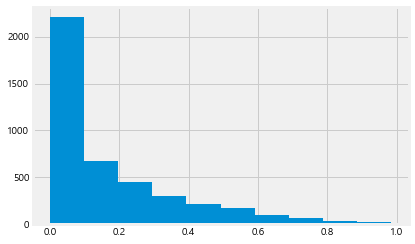

In [136]:
submission['pred'].hist()

Learning rate set to 0.039306
0:	learn: 0.6582369	total: 52.1ms	remaining: 52.1s
1:	learn: 0.6265029	total: 114ms	remaining: 57s
2:	learn: 0.5978115	total: 172ms	remaining: 57.2s
3:	learn: 0.5718222	total: 224ms	remaining: 55.8s
4:	learn: 0.5482621	total: 302ms	remaining: 1m
5:	learn: 0.5269266	total: 365ms	remaining: 1m
6:	learn: 0.5075900	total: 428ms	remaining: 1m
7:	learn: 0.4898860	total: 491ms	remaining: 1m
8:	learn: 0.4738833	total: 556ms	remaining: 1m 1s
9:	learn: 0.4594654	total: 603ms	remaining: 59.7s
10:	learn: 0.4459282	total: 652ms	remaining: 58.6s
11:	learn: 0.4341090	total: 717ms	remaining: 59s
12:	learn: 0.4230935	total: 780ms	remaining: 59.2s
13:	learn: 0.4130648	total: 875ms	remaining: 1m 1s
14:	learn: 0.4040693	total: 954ms	remaining: 1m 2s
15:	learn: 0.3960108	total: 1s	remaining: 1m 1s
16:	learn: 0.3887840	total: 1.08s	remaining: 1m 2s
17:	learn: 0.3822135	total: 1.17s	remaining: 1m 4s
18:	learn: 0.3762456	total: 1.24s	remaining: 1m 3s
19:	learn: 0.3706192	total: 1

162:	learn: 0.2410872	total: 10.1s	remaining: 51.7s
163:	learn: 0.2405554	total: 10.1s	remaining: 51.6s
164:	learn: 0.2404254	total: 10.2s	remaining: 51.5s
165:	learn: 0.2403369	total: 10.2s	remaining: 51.4s
166:	learn: 0.2402631	total: 10.3s	remaining: 51.3s
167:	learn: 0.2401549	total: 10.3s	remaining: 51.1s
168:	learn: 0.2399593	total: 10.4s	remaining: 51.2s
169:	learn: 0.2398265	total: 10.5s	remaining: 51s
170:	learn: 0.2396726	total: 10.5s	remaining: 50.9s
171:	learn: 0.2395937	total: 10.6s	remaining: 50.9s
172:	learn: 0.2395502	total: 10.7s	remaining: 51s
173:	learn: 0.2393345	total: 10.7s	remaining: 50.9s
174:	learn: 0.2391413	total: 10.8s	remaining: 50.8s
175:	learn: 0.2388886	total: 10.8s	remaining: 50.7s
176:	learn: 0.2385098	total: 10.9s	remaining: 50.8s
177:	learn: 0.2382977	total: 11s	remaining: 50.7s
178:	learn: 0.2380695	total: 11s	remaining: 50.6s
179:	learn: 0.2378952	total: 11.1s	remaining: 50.5s
180:	learn: 0.2375892	total: 11.1s	remaining: 50.4s
181:	learn: 0.237310

325:	learn: 0.2089282	total: 19.1s	remaining: 39.4s
326:	learn: 0.2088279	total: 19.1s	remaining: 39.4s
327:	learn: 0.2087212	total: 19.2s	remaining: 39.3s
328:	learn: 0.2085937	total: 19.3s	remaining: 39.3s
329:	learn: 0.2084272	total: 19.3s	remaining: 39.2s
330:	learn: 0.2083134	total: 19.4s	remaining: 39.2s
331:	learn: 0.2081023	total: 19.4s	remaining: 39.1s
332:	learn: 0.2079142	total: 19.5s	remaining: 39.1s
333:	learn: 0.2077560	total: 19.6s	remaining: 39.1s
334:	learn: 0.2076123	total: 19.6s	remaining: 39s
335:	learn: 0.2075408	total: 19.7s	remaining: 38.9s
336:	learn: 0.2071462	total: 19.7s	remaining: 38.8s
337:	learn: 0.2068315	total: 19.8s	remaining: 38.7s
338:	learn: 0.2066822	total: 19.8s	remaining: 38.7s
339:	learn: 0.2066123	total: 19.9s	remaining: 38.6s
340:	learn: 0.2065791	total: 20s	remaining: 38.6s
341:	learn: 0.2063675	total: 20s	remaining: 38.5s
342:	learn: 0.2062030	total: 20.1s	remaining: 38.5s
343:	learn: 0.2060592	total: 20.1s	remaining: 38.4s
344:	learn: 0.2059

487:	learn: 0.1871233	total: 28.6s	remaining: 30s
488:	learn: 0.1870603	total: 28.7s	remaining: 30s
489:	learn: 0.1868090	total: 28.7s	remaining: 29.9s
490:	learn: 0.1867092	total: 28.8s	remaining: 29.9s
491:	learn: 0.1865610	total: 28.9s	remaining: 29.8s
492:	learn: 0.1863754	total: 28.9s	remaining: 29.8s
493:	learn: 0.1862840	total: 29s	remaining: 29.7s
494:	learn: 0.1861279	total: 29s	remaining: 29.6s
495:	learn: 0.1860393	total: 29.1s	remaining: 29.6s
496:	learn: 0.1859281	total: 29.2s	remaining: 29.6s
497:	learn: 0.1857561	total: 29.3s	remaining: 29.5s
498:	learn: 0.1855365	total: 29.3s	remaining: 29.4s
499:	learn: 0.1853777	total: 29.4s	remaining: 29.4s
500:	learn: 0.1852500	total: 29.5s	remaining: 29.3s
501:	learn: 0.1852115	total: 29.5s	remaining: 29.3s
502:	learn: 0.1850494	total: 29.5s	remaining: 29.2s
503:	learn: 0.1849374	total: 29.6s	remaining: 29.1s
504:	learn: 0.1847229	total: 29.6s	remaining: 29.1s
505:	learn: 0.1846590	total: 29.7s	remaining: 29s
506:	learn: 0.1845272	

647:	learn: 0.1694517	total: 38.3s	remaining: 20.8s
648:	learn: 0.1692853	total: 38.3s	remaining: 20.7s
649:	learn: 0.1691564	total: 38.4s	remaining: 20.7s
650:	learn: 0.1691174	total: 38.5s	remaining: 20.6s
651:	learn: 0.1690529	total: 38.5s	remaining: 20.6s
652:	learn: 0.1689146	total: 38.6s	remaining: 20.5s
653:	learn: 0.1687504	total: 38.6s	remaining: 20.4s
654:	learn: 0.1686892	total: 38.7s	remaining: 20.4s
655:	learn: 0.1685726	total: 38.7s	remaining: 20.3s
656:	learn: 0.1684194	total: 38.8s	remaining: 20.2s
657:	learn: 0.1683550	total: 38.8s	remaining: 20.2s
658:	learn: 0.1682323	total: 38.9s	remaining: 20.1s
659:	learn: 0.1681290	total: 38.9s	remaining: 20.1s
660:	learn: 0.1680693	total: 39s	remaining: 20s
661:	learn: 0.1679765	total: 39s	remaining: 19.9s
662:	learn: 0.1679283	total: 39.1s	remaining: 19.9s
663:	learn: 0.1678584	total: 39.2s	remaining: 19.8s
664:	learn: 0.1678002	total: 39.2s	remaining: 19.7s
665:	learn: 0.1677486	total: 39.2s	remaining: 19.7s
666:	learn: 0.1676

808:	learn: 0.1557957	total: 47.1s	remaining: 11.1s
809:	learn: 0.1557108	total: 47.2s	remaining: 11.1s
810:	learn: 0.1556284	total: 47.2s	remaining: 11s
811:	learn: 0.1554577	total: 47.3s	remaining: 10.9s
812:	learn: 0.1553774	total: 47.4s	remaining: 10.9s
813:	learn: 0.1552789	total: 47.4s	remaining: 10.8s
814:	learn: 0.1552053	total: 47.4s	remaining: 10.8s
815:	learn: 0.1551316	total: 47.5s	remaining: 10.7s
816:	learn: 0.1550997	total: 47.5s	remaining: 10.6s
817:	learn: 0.1549481	total: 47.6s	remaining: 10.6s
818:	learn: 0.1549180	total: 47.7s	remaining: 10.5s
819:	learn: 0.1548610	total: 47.7s	remaining: 10.5s
820:	learn: 0.1547815	total: 47.8s	remaining: 10.4s
821:	learn: 0.1546681	total: 47.9s	remaining: 10.4s
822:	learn: 0.1546384	total: 48s	remaining: 10.3s
823:	learn: 0.1545126	total: 48s	remaining: 10.3s
824:	learn: 0.1544153	total: 48.1s	remaining: 10.2s
825:	learn: 0.1543065	total: 48.1s	remaining: 10.1s
826:	learn: 0.1542498	total: 48.2s	remaining: 10.1s
827:	learn: 0.1541

967:	learn: 0.1423327	total: 56.2s	remaining: 1.86s
968:	learn: 0.1422589	total: 56.2s	remaining: 1.8s
969:	learn: 0.1422531	total: 56.3s	remaining: 1.74s
970:	learn: 0.1422040	total: 56.3s	remaining: 1.68s
971:	learn: 0.1421710	total: 56.4s	remaining: 1.62s
972:	learn: 0.1421230	total: 56.4s	remaining: 1.56s
973:	learn: 0.1420703	total: 56.5s	remaining: 1.51s
974:	learn: 0.1419829	total: 56.5s	remaining: 1.45s
975:	learn: 0.1418896	total: 56.6s	remaining: 1.39s
976:	learn: 0.1418292	total: 56.6s	remaining: 1.33s
977:	learn: 0.1417966	total: 56.7s	remaining: 1.27s
978:	learn: 0.1417090	total: 56.7s	remaining: 1.22s
979:	learn: 0.1416822	total: 56.8s	remaining: 1.16s
980:	learn: 0.1416392	total: 56.8s	remaining: 1.1s
981:	learn: 0.1416020	total: 56.9s	remaining: 1.04s
982:	learn: 0.1415736	total: 57s	remaining: 985ms
983:	learn: 0.1415603	total: 57s	remaining: 927ms
984:	learn: 0.1414842	total: 57.1s	remaining: 869ms
985:	learn: 0.1414794	total: 57.1s	remaining: 811ms
986:	learn: 0.1414

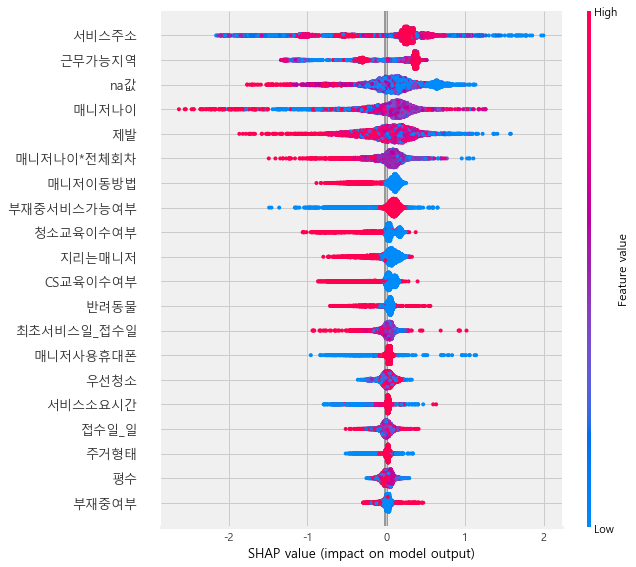

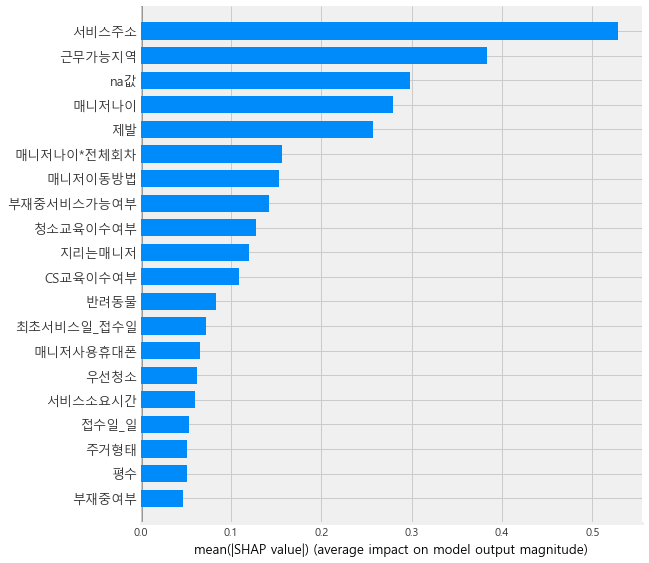

In [329]:
#SHAP로 피쳐임포턴스 확인
import shap


X_importance = ftr_te_imputed

model = CatBoostClassifier(random_state=0).fit(ftr_imputed, target)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)


#model = LGBMRegressor(random_state=0).fit(X_train_scaled, y)
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot
shap.summary_plot(shap_values, X_importance, plot_type='bar')

#shap_sum = np.abs(shap_values).mean(axis=0)
#importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
#importance_df.columns = ['column_name', 'shap_importance']
#importance_df = importance_df.sort_values('shap_importance', ascending=False)
#importance_df

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

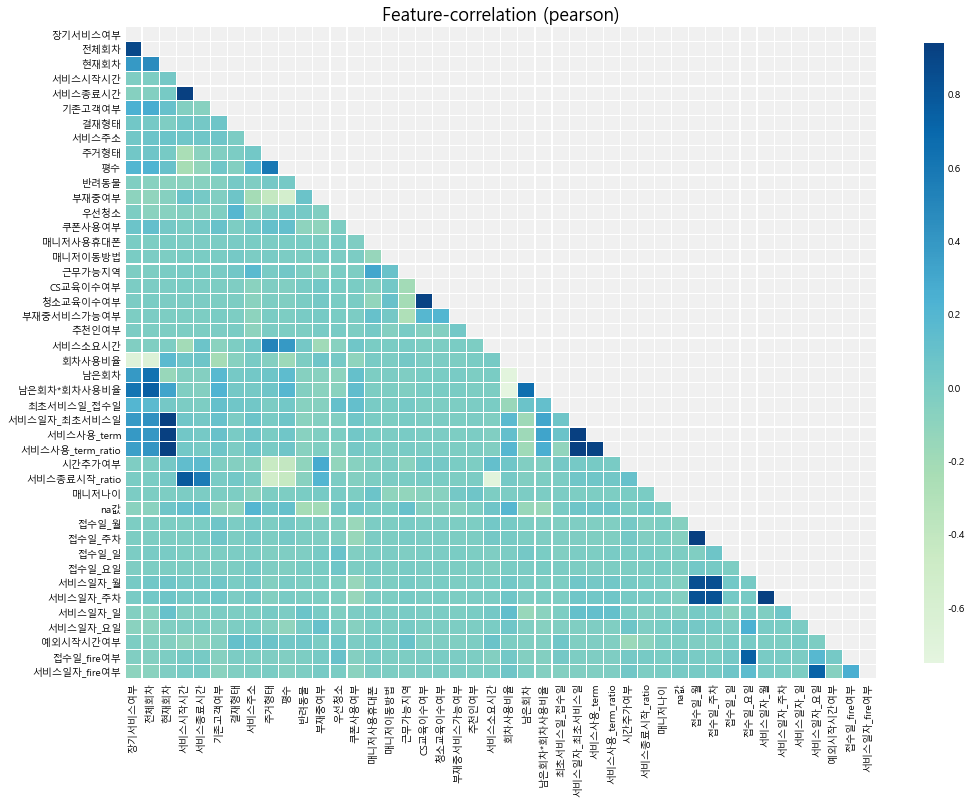

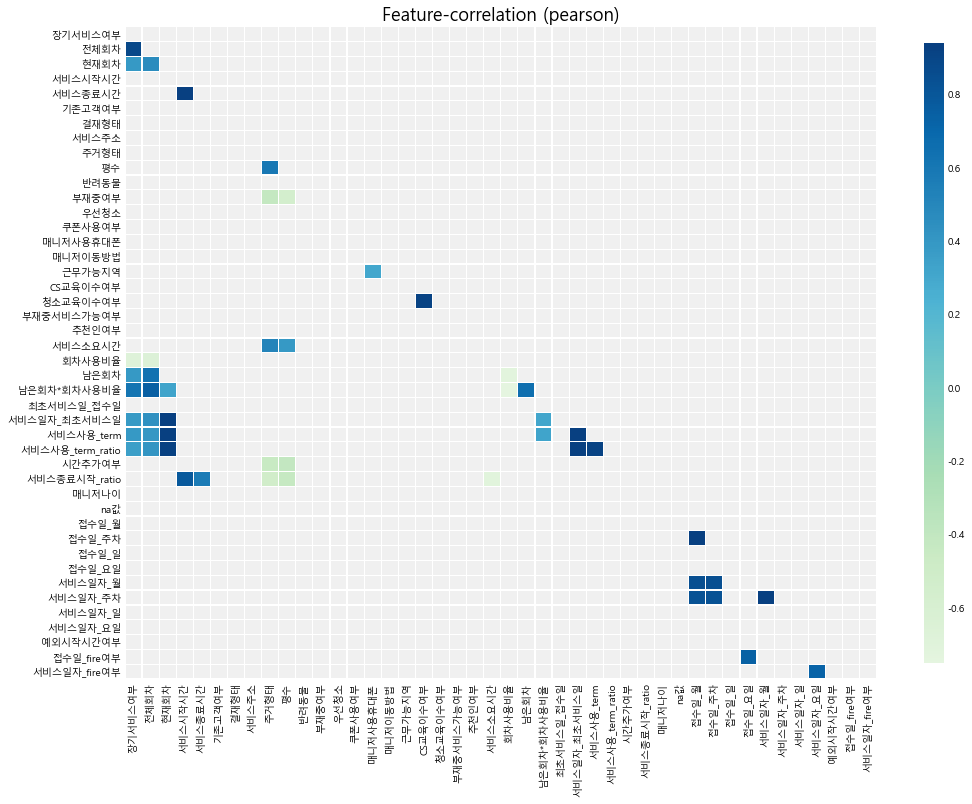

In [61]:
# 속성간 유사성 파악 통계학에서는
import klib
klib.corr_plot(ftr_imputed, annot=False, figsize=(15,12),cmap='GnBu',linewidths=0.2)
klib.corr_plot(ftr_imputed, cmap='GnBu',linewidths=0.2,split='high', annot=False, figsize=(15,12))